In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import unet

In [ ]:
def train(data_path, model_path):
    data = np.load(data_path)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(data['pred_vars']) # Shape: (nsamples, channels/variables, width, height)
    y_tensor = torch.FloatTensor(data['target_vars'][:, np.newaxis, :, :]) # Add channel dimension

    # First split: 80% train, 20% temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=42
    )

    # Second split: 50% val, 50% test (10% each of full dataset)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    # Convert test tensors to numpy arrays
    X_test_np = X_test.numpy()
    y_test_np = y_test.numpy()

    # Save test set as .npz file
    np.savez(
        'data/test_set.npz',  # Filename
        X_test=X_test_np,  # Save predictors
        y_test=y_test_np   # Save targets
    )

    print(f"Training set: {X_train.shape}, {y_train.shape}")
    print(f"Validation set: {X_val.shape}, {y_val.shape}")
    print(f"Test set: {X_test.shape}, {y_test.shape}")

    batch_size = 6  # Adjust based on memory
    train_loader = DataLoader(TensorDataset(X_train, y_train), 
                             batch_size=batch_size, 
                             shuffle=True)  
    val_loader = DataLoader(TensorDataset(X_val, y_val), 
                           batch_size=batch_size, 
                           shuffle=True)

    # Initialize model, loss, optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = unet.UNET().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # Variables for tracking best model and training history
    best_val_loss = float('inf')
    train_loss_history = []
    val_loss_history = []

    # Training loop 
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.mse_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += F.mse_loss(outputs, targets).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        
        # Store losses for plotting
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved with val loss: {best_val_loss:.4f}")

        if epoch % 10 == 0:
            with torch.no_grad():
                inputs, targets = next(iter(val_loader))
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                
                pred_img = outputs[0, 0].cpu().numpy()
                target_img = targets[0, 0].cpu().numpy()
                
                fig, axs = plt.subplots(1, 2, figsize=(12, 4))
                
                # Plot prediction with colorbar
                im1 = axs[0].imshow(pred_img, cmap='viridis')
                axs[0].set_title("Prediction")
                fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
                
                # Plot target with colorbar
                im2 = axs[1].imshow(target_img, cmap='viridis', vmin=0, vmax=10)
                axs[1].set_title("Target")
                fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
                
                plt.tight_layout()
                plt.show()
                print(f'Epoch {epoch+1}/{num_epochs}')
                print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Final epoch print
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('figures/training_loss_plot.png') 
    plt.show()

    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Training complete. Best model saved to {model_path}")
    print("Training loss plot saved as 'training_loss_plot.png'")

Test set saved as 'test_set.npz'
Training set: torch.Size([873, 8, 336, 336]), torch.Size([873, 1, 336, 336])
Validation set: torch.Size([109, 8, 336, 336]), torch.Size([109, 1, 336, 336])
Test set: torch.Size([110, 8, 336, 336]), torch.Size([110, 1, 336, 336])
New best model saved with val loss: 0.1798


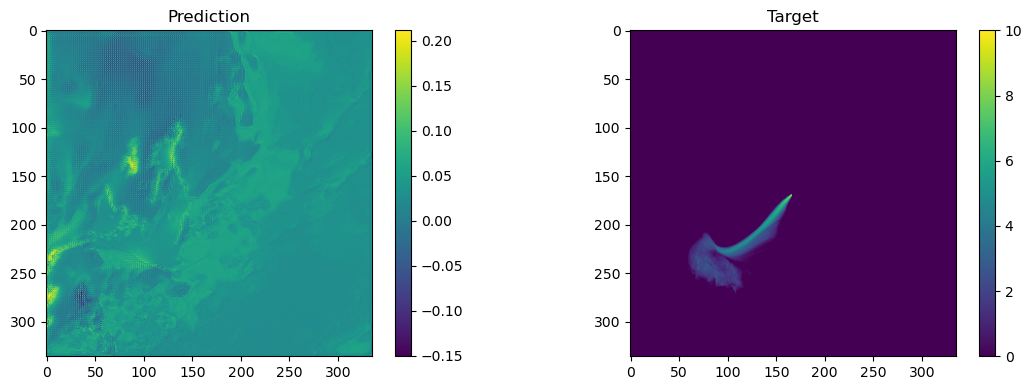

Epoch 1/100
Train Loss: 0.1844, Val Loss: 0.1798
New best model saved with val loss: 0.1789


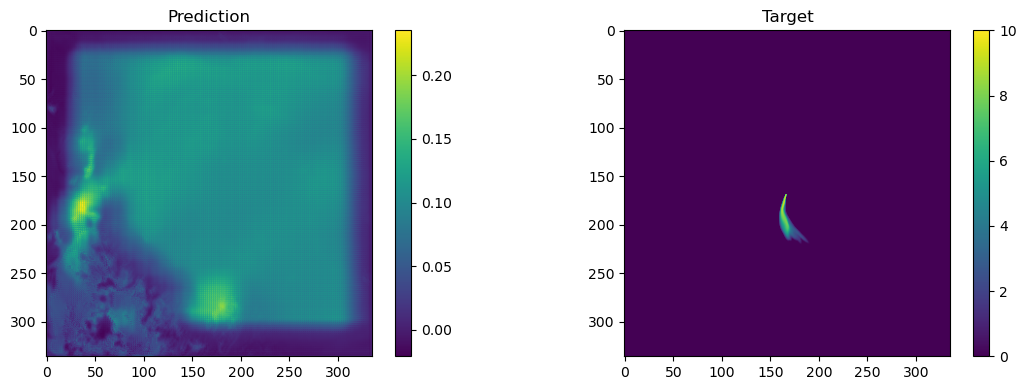

Epoch 6/100
Train Loss: 0.1770, Val Loss: 0.1857
New best model saved with val loss: 0.1777
New best model saved with val loss: 0.1725


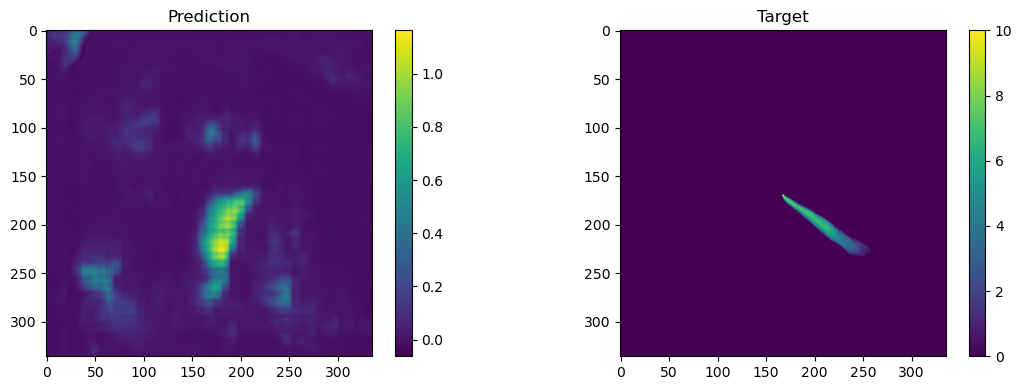

Epoch 11/100
Train Loss: 0.1671, Val Loss: 0.1747
New best model saved with val loss: 0.1643
New best model saved with val loss: 0.1633


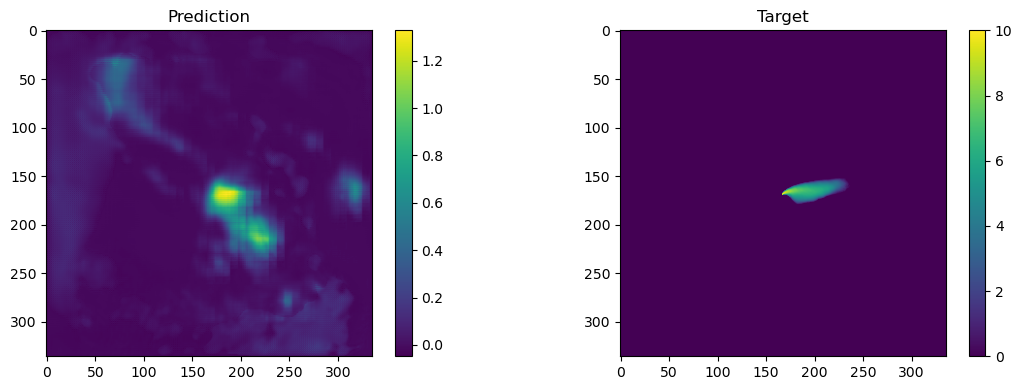

Epoch 16/100
Train Loss: 0.1539, Val Loss: 0.1658
New best model saved with val loss: 0.1566
New best model saved with val loss: 0.1414


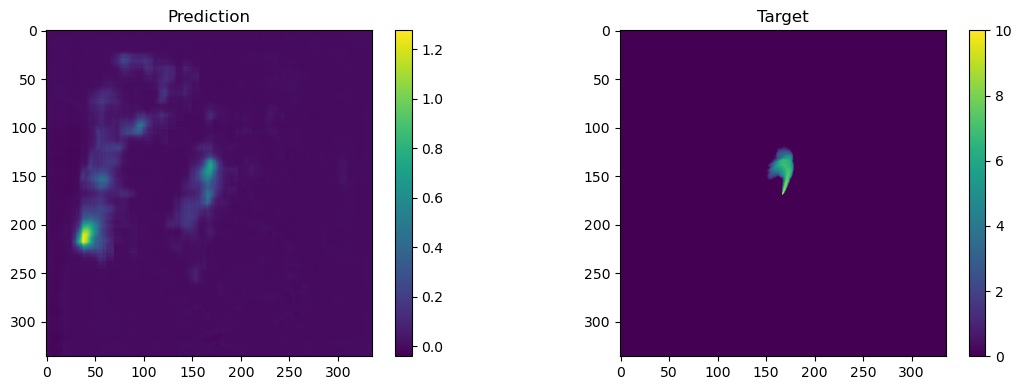

Epoch 21/100
Train Loss: 0.1447, Val Loss: 0.1414
New best model saved with val loss: 0.1314


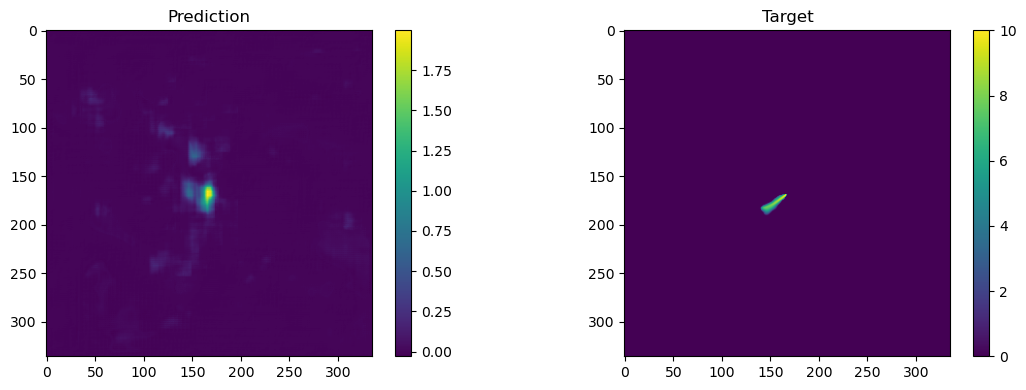

Epoch 26/100
Train Loss: 0.1287, Val Loss: 0.1314
New best model saved with val loss: 0.1313
New best model saved with val loss: 0.1293
New best model saved with val loss: 0.1258


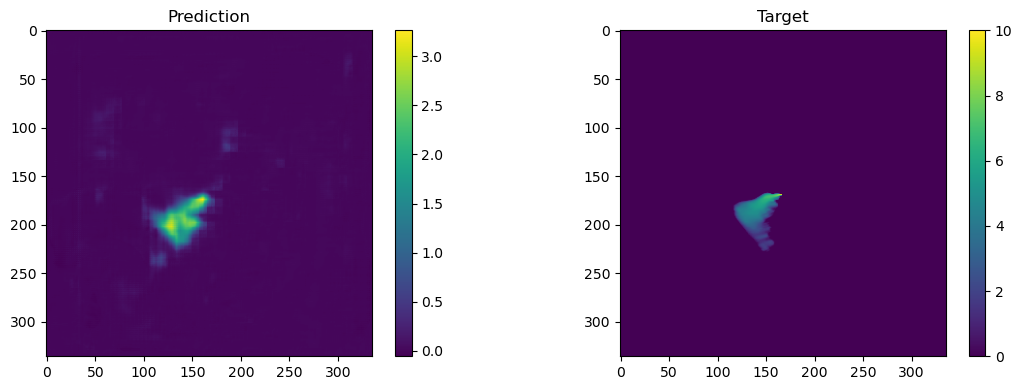

Epoch 31/100
Train Loss: 0.1176, Val Loss: 0.1277
New best model saved with val loss: 0.1242


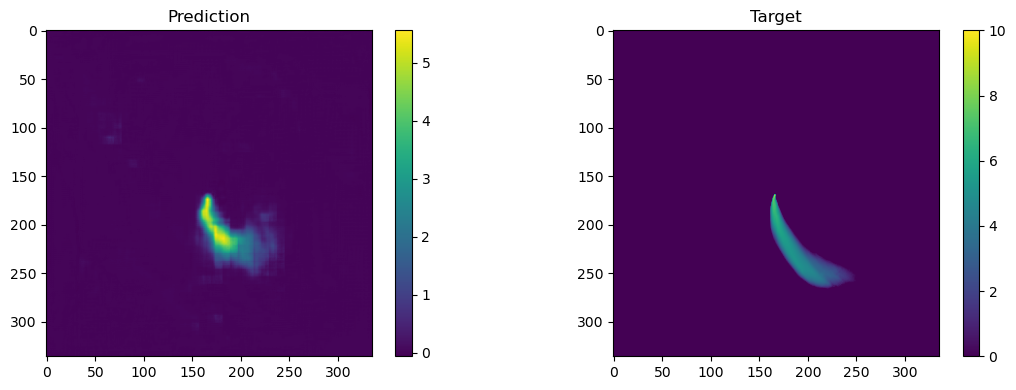

Epoch 36/100
Train Loss: 0.1124, Val Loss: 0.1285
New best model saved with val loss: 0.1223
New best model saved with val loss: 0.1191


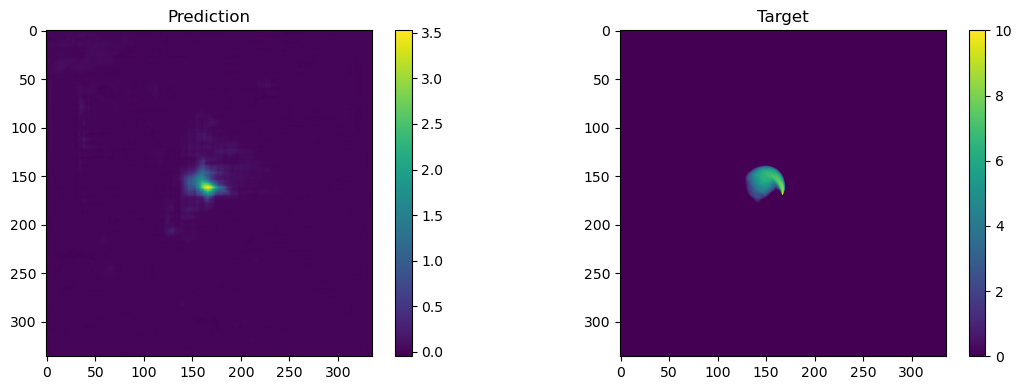

Epoch 41/100
Train Loss: 0.1104, Val Loss: 0.1195


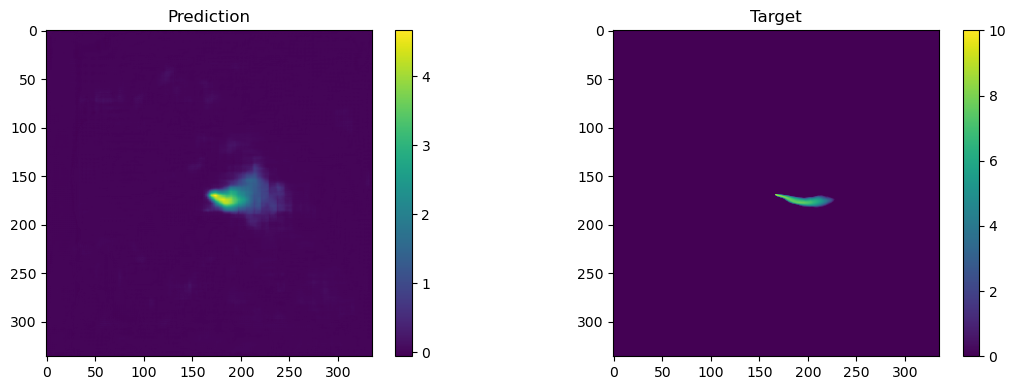

Epoch 46/100
Train Loss: 0.1099, Val Loss: 0.1219


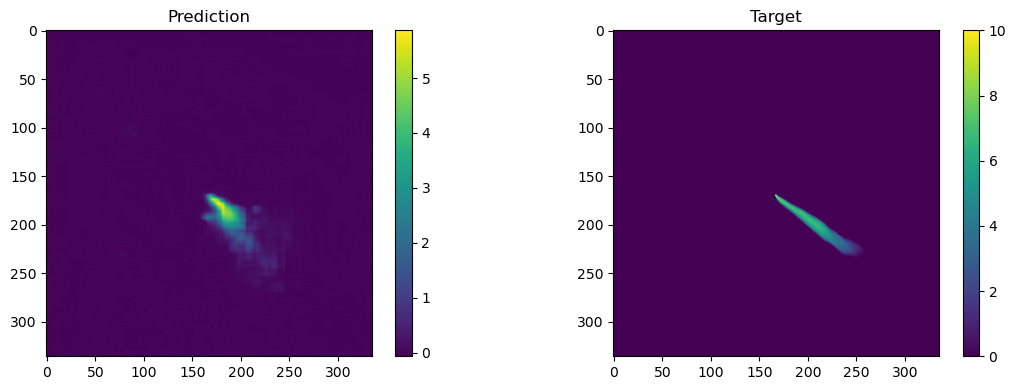

Epoch 51/100
Train Loss: 0.1090, Val Loss: 0.1237


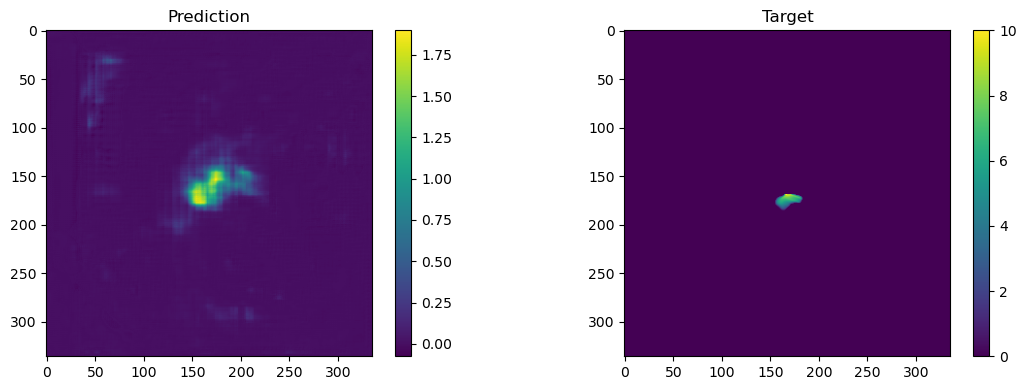

Epoch 56/100
Train Loss: 0.1091, Val Loss: 0.1214


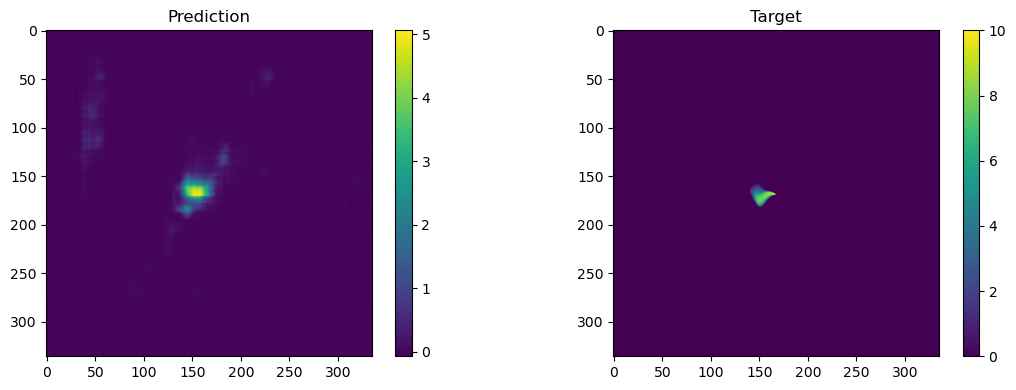

Epoch 61/100
Train Loss: 0.1089, Val Loss: 0.1220


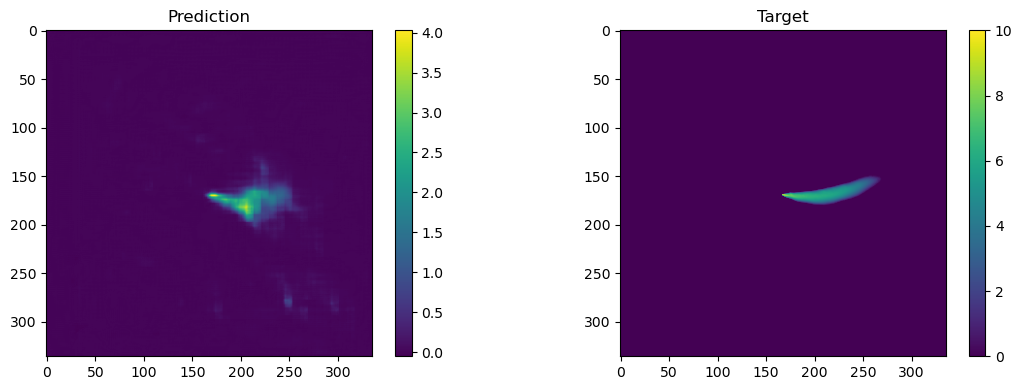

Epoch 66/100
Train Loss: 0.1088, Val Loss: 0.1232


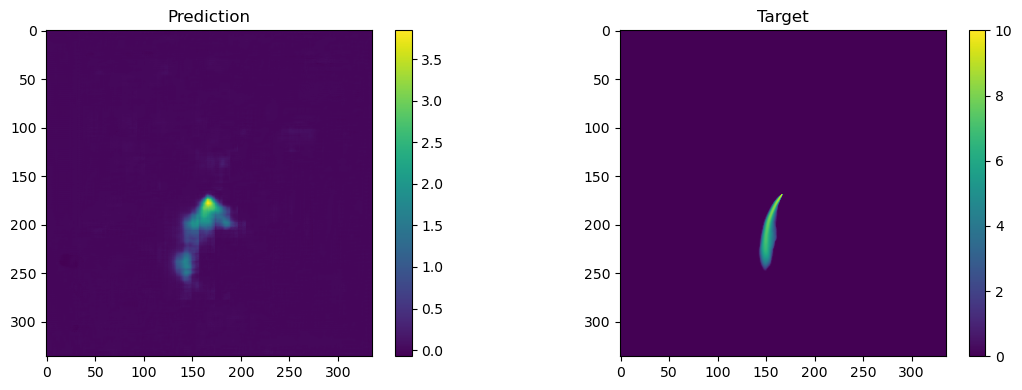

Epoch 71/100
Train Loss: 0.1105, Val Loss: 0.1246


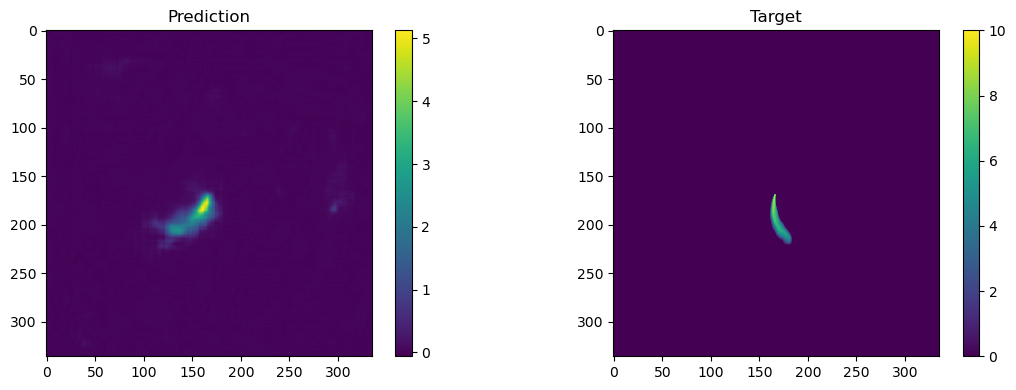

Epoch 76/100
Train Loss: 0.1108, Val Loss: 0.1251


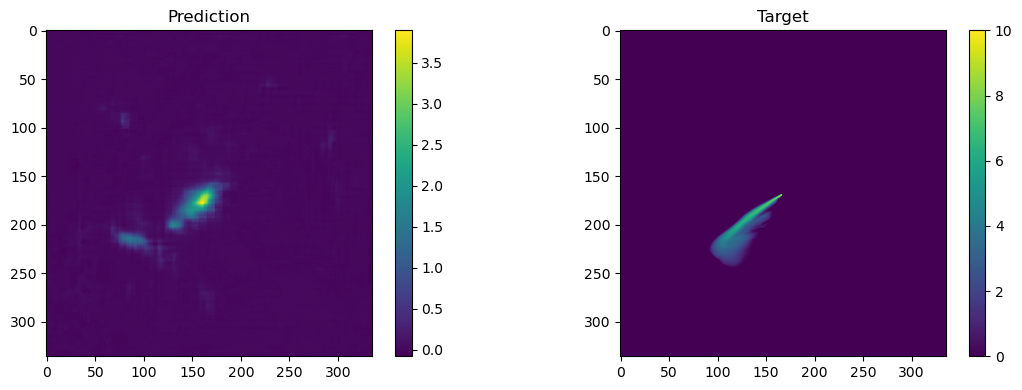

Epoch 81/100
Train Loss: 0.1088, Val Loss: 0.1276


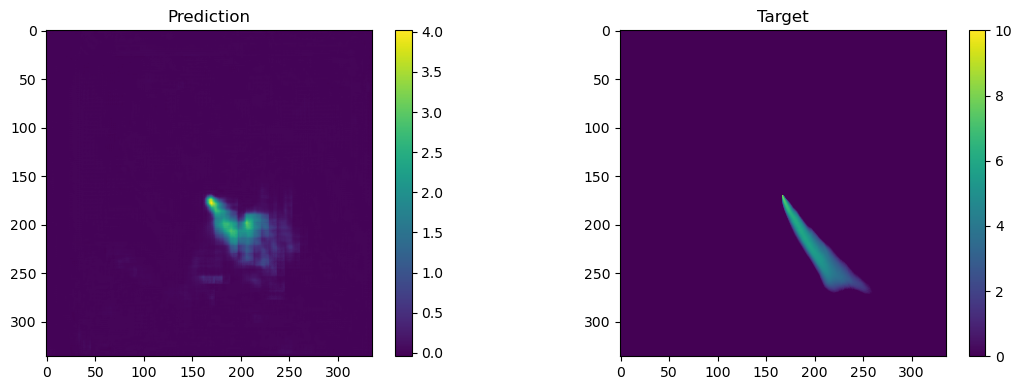

Epoch 86/100
Train Loss: 0.1093, Val Loss: 0.1230


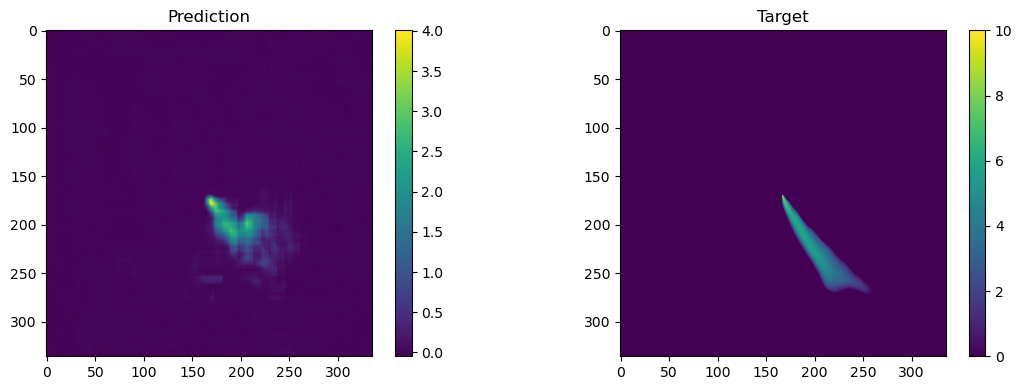

Epoch 91/100
Train Loss: 0.1094, Val Loss: 0.1208


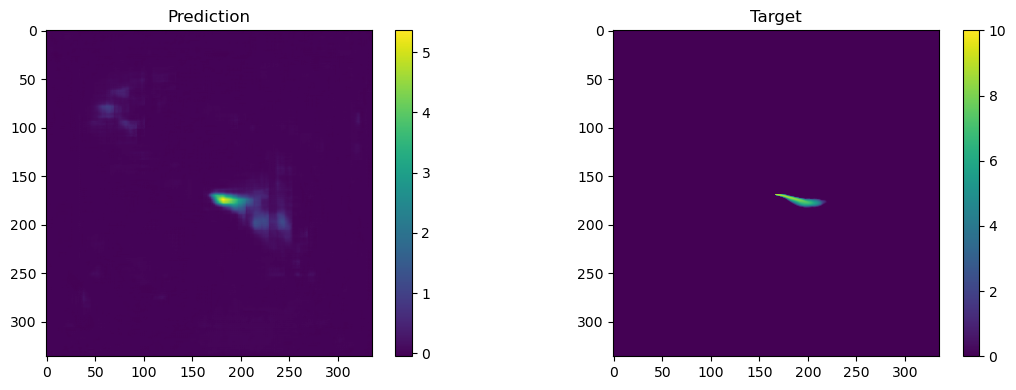

Epoch 96/100
Train Loss: 0.1091, Val Loss: 0.1217
Epoch 100/100
Train Loss: 0.1104, Val Loss: 0.1272


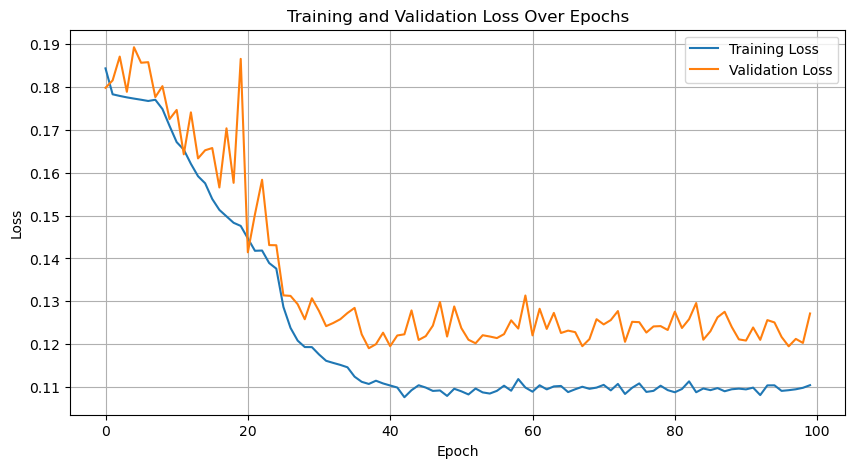

Best validation loss: 0.1191
Training complete. Best model saved to models/unet_accumulated_100_lr001.pth
Training loss plot saved as 'training_loss_plot.png'


In [ ]:
x_data_path = 'data/sample_training_data.npz'

train(x_data_path, 'models/unet_emulator_sample.pth')